In [1]:
import torch
import torchvision
import cv2
from torch import nn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms as tt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

In [2]:
# from torchvision.models.video import s3d,S3D_Weights,mc3_18,MC3_18_Weights,mvit_v2_s,MViT_V2_S_Weights

In [3]:
# pip install youtube-dl

In [4]:
# pip install git+https://github.com/pytorch/tnt.git@master

In [5]:
# ! git clone https://github.com/leftthomas/R2Plus1D-C3D

## Download.py

In [6]:
# https://github.com/murilovarges/R2Plus1D


## Loading data

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
torch.random.seed= seed_constant

BATCH_SIZE=10

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 112, 112

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]


In [3]:
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

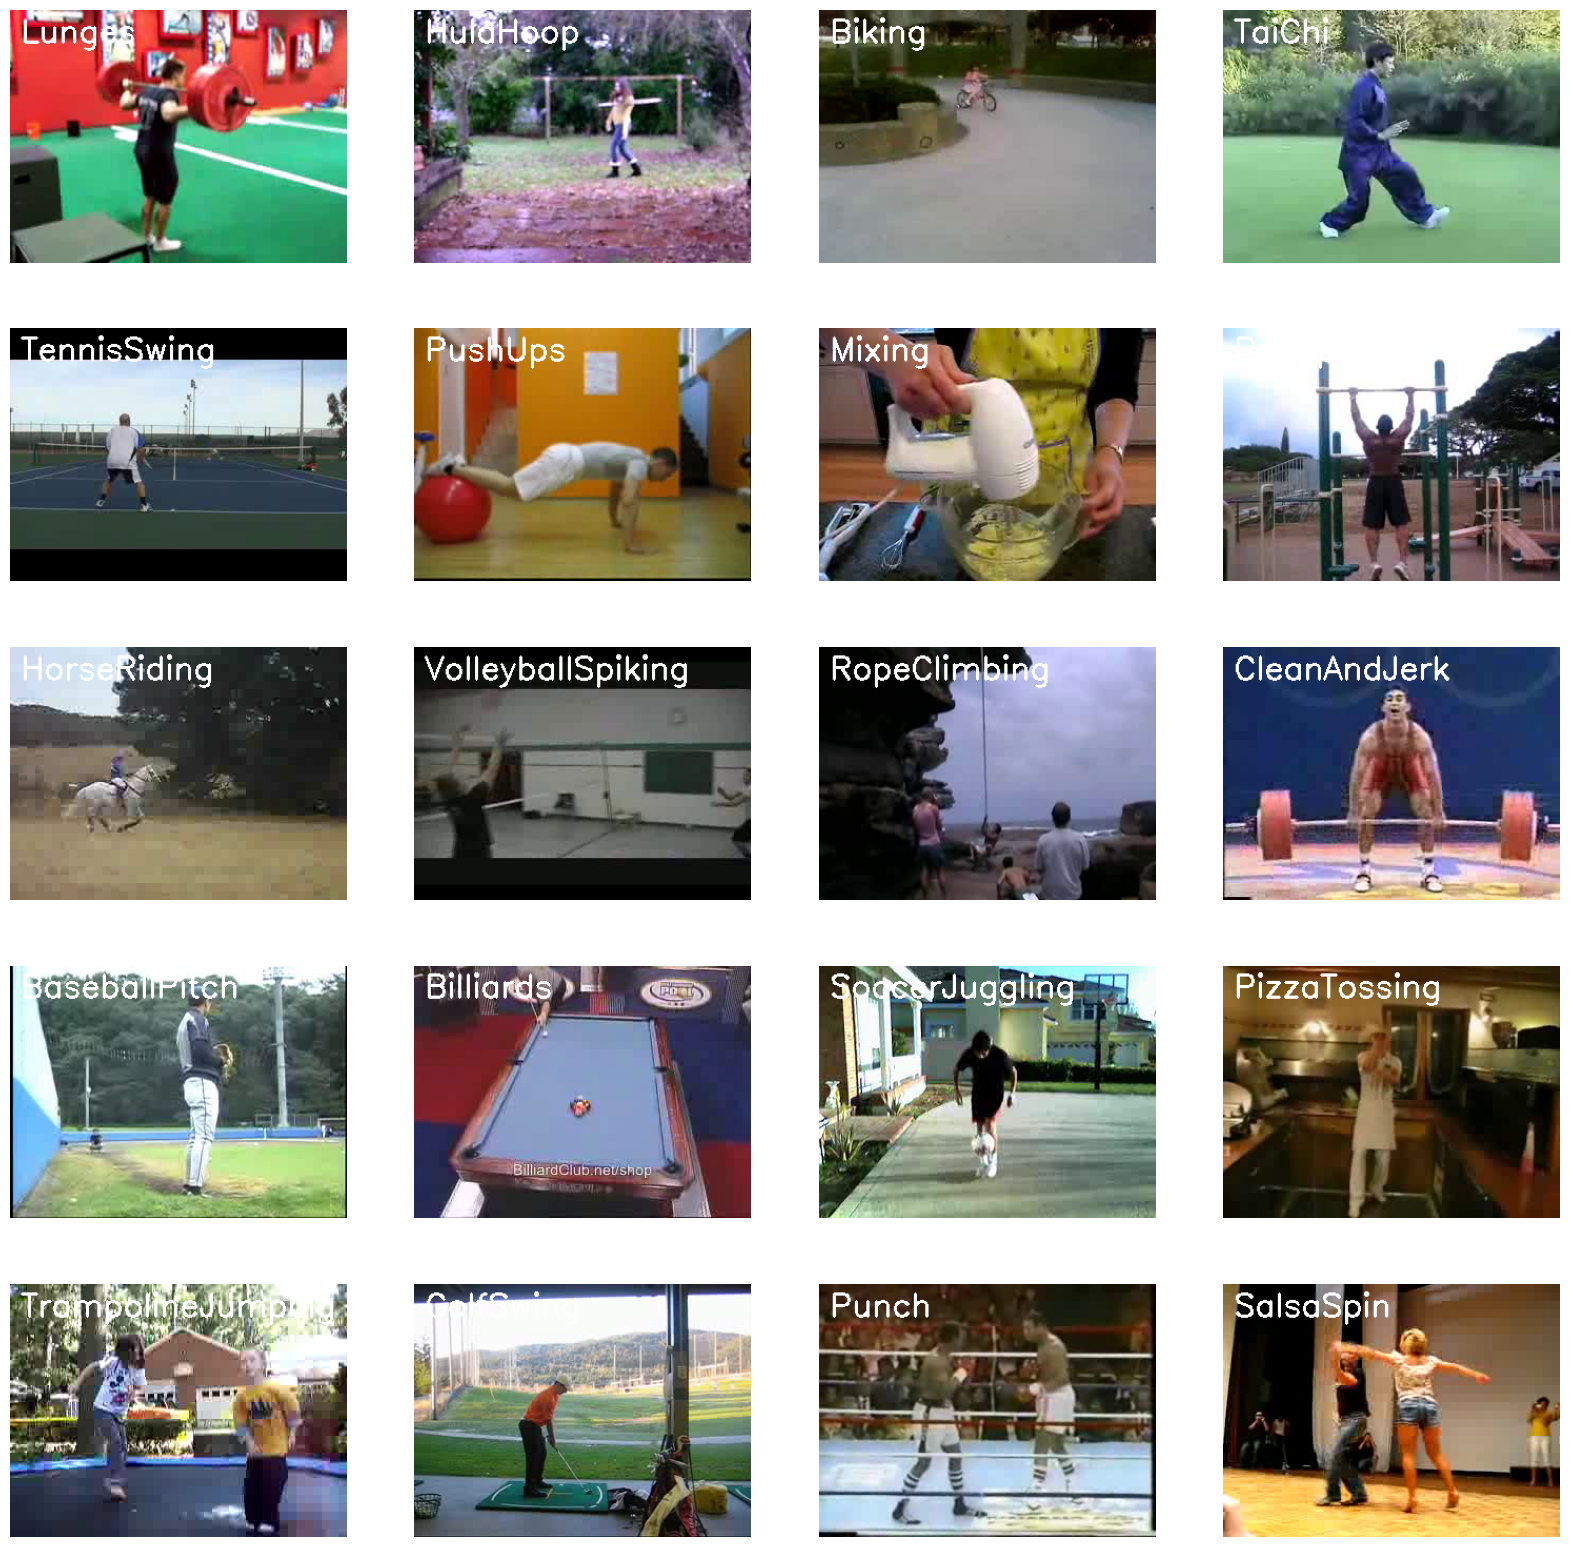

In [4]:
 #Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## Frame Extraction

In [5]:
def frames_extraction(video_path,TIME_SECODNS=3):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    # Getting total frames in the video
    frame_count=video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    # Getting Frames per seconds for video
    FPS=video_reader.get(cv2.CAP_PROP_FPS)
    # finding video length in seconds
    vid_len=frame_count/FPS
    # keeping first 3 seconds of the video
    thresh_frames=int(frame_count-((vid_len-TIME_SECODNS)*FPS))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(thresh_frames/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [6]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [7]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [8]:
vide_trans=tt.Compose([R2Plus1D_18_Weights.KINETICS400_V1.transforms()])

In [9]:
def apply_tansforms(feat):
  feats=[]
  for i in range(len(feat)):
      x=np.transpose(np.array(feat[i]), (0,3,1,2))
      a=torch.Tensor(x)
      # print("No Prob")
      feats.append(vide_trans(a))
  return feats

In [10]:
feats=apply_tansforms(features)

In [11]:
labels=torch.tensor(labels)
labels.shape

torch.Size([486])

In [12]:
len(feats)

486

## Creating Datasets

In [13]:
x_train,x_test,y_train,y_test=train_test_split(feats,labels,stratify=labels,test_size=0.25,shuffle=True,random_state=seed_constant)

In [14]:
len(x_train)

364

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [16]:
class ActDS(Dataset):
    def __init__(self, feats,lbels, device = device):
        self.features = feats
        self.device = device
        self.labels = lbels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        labels = self.labels[index]

        # Convert to PyTorch tensors
        features = features.to(device)
        labels = labels.to(device)

        return features, labels

In [17]:
train_ds = ActDS(x_train,y_train)
test_ds = ActDS(x_test,y_test)

In [66]:
for i in x_train:
  print(i.shape)
  break

torch.Size([3, 10, 112, 112])


## Creating DataLoaders

In [18]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Trochvision transfer learning

### r2plus1

In [39]:
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights



In [40]:
weights=R2Plus1D_18_Weights.DEFAULT
r21dd=r2plus1d_18(weights=weights,progress=True)
in_fc=r21dd.fc.in_features
in_fc

512

In [41]:
r21dd.fc=nn.Linear(in_fc,4,bias=True)

In [42]:
for param in r21dd.parameters():
   param.requires_grad=False
r21dd.fc.weight.requires_grad = True
r21dd.fc.bias.requires_grad = True

In [43]:
model=r21dd.to(device)

## Training

In [45]:
from sklearn.metrics import accuracy_score
EPOCHS=10
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
loss_fn = nn.CrossEntropyLoss()

In [46]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

# Train the model for multiple epochs

for epoch in range(EPOCHS):

    # Training loop
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader):

        inputs, targets = data

        optimizer.zero_grad()

        outputs = model(inputs)

        preds = torch.argmax(outputs, dim = 1)

        batch_loss = loss_fn(outputs, targets)
        batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())

        batch_loss.backward()

        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
        # print("train_acc: ",train_acc)
        # print("input_size: ",inputs.size(0))
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)

    loss.append(train_loss)
    acc.append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():

        for data in test_loader:

            inputs, targets = data

            outputs = model(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, targets)

            batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:1.1977, test:0.9759 | Acc - train:0.4890, test:0.6475
At epoch 1 | Loss - train:0.6889, test:0.6636 | Acc - train:0.8681, test:0.8607
At epoch 2 | Loss - train:0.4894, test:0.5334 | Acc - train:0.9258, test:0.9426
At epoch 3 | Loss - train:0.4152, test:0.4684 | Acc - train:0.9121, test:0.9098
At epoch 4 | Loss - train:0.3161, test:0.4210 | Acc - train:0.9505, test:0.9180
At epoch 5 | Loss - train:0.3453, test:0.3928 | Acc - train:0.9066, test:0.9180
At epoch 6 | Loss - train:0.2669, test:0.3522 | Acc - train:0.9313, test:0.9344
At epoch 7 | Loss - train:0.2607, test:0.3535 | Acc - train:0.9313, test:0.9180
At epoch 8 | Loss - train:0.2351, test:0.3290 | Acc - train:0.9533, test:0.9344
At epoch 9 | Loss - train:0.1941, test:0.3294 | Acc - train:0.9725, test:0.9180


In [29]:
loss_df=pd.DataFrame({"loss":loss,"acc":acc,"val_loss":tloss,"val_acc":tacc})
loss_df

loss       acc  val_loss   val_acc
0  1.118461  0.574176  0.894847  0.754098
1  0.658542  0.881868  0.667206  0.844262
2  0.457130  0.925824  0.533827  0.868852
3  0.448448  0.901099  0.467976  0.885246
4  0.315743  0.936813  0.415253  0.893443
5  0.312332  0.928571  0.415937  0.926230
6  0.268294  0.928571  0.373976  0.918033
7  0.216972  0.950549  0.345720  0.918033
8  0.223915  0.947802  0.339170  0.909836
9  0.177180  0.964286  0.313432  0.918033

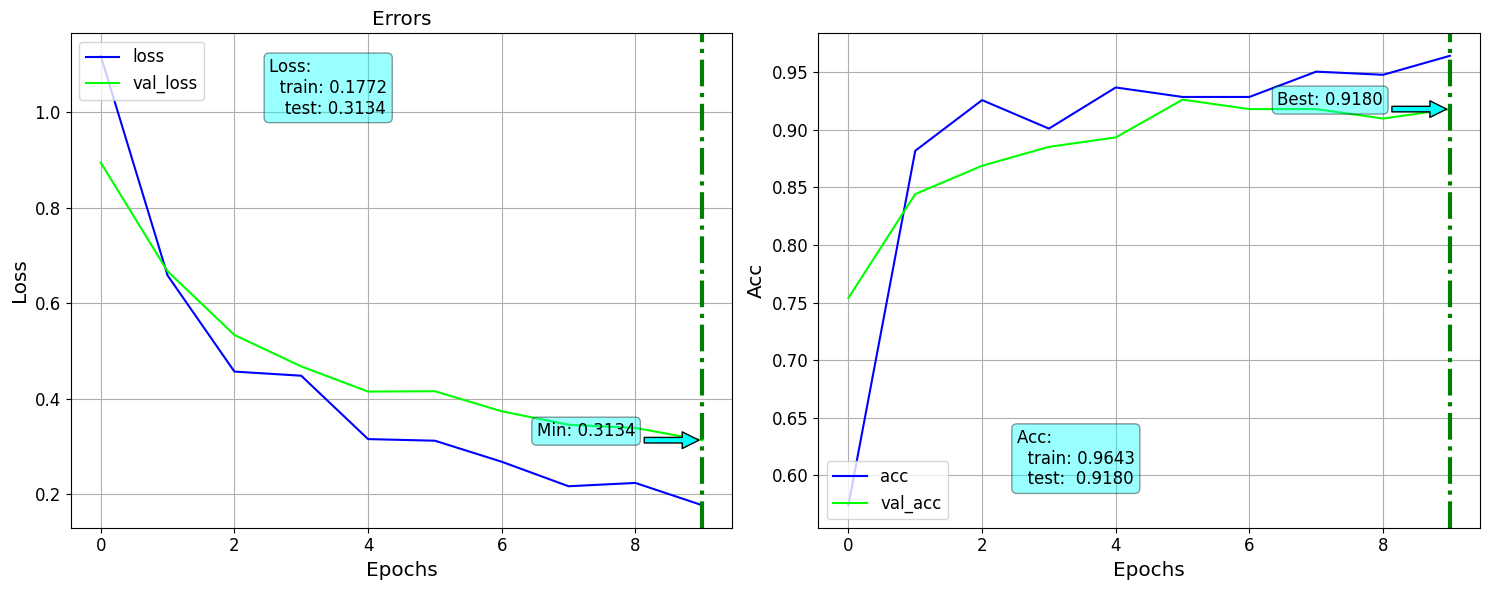

In [47]:
plot_tf_hist(loss_df)


## Predictions

In [169]:
def val_frames_extraction(video_path,TIME_SECODNS=3):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    vid_list=[]
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    # Get Frame counts
    frame_count=video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    # Get FPS
    FPS=video_reader.get(cv2.CAP_PROP_FPS)
    # Find video length
    vid_len=frame_count/FPS
    # Finding frames in 3 seconds window
    thresh_frames=int(frame_count-((vid_len-TIME_SECODNS)*FPS))

    # Get the total number of frames in the video.
    # video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    # as we need 10 frames for each 3 second video
    skip_frames_window = max(int(thresh_frames/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    n_videos=int(vid_len/3)
    print(vid_len/3)
    for i in range(n_videos):
      count=i*SEQUENCE_LENGTH
      for frame_counter in range(SEQUENCE_LENGTH):
          # Set the current frame position of the video.
          video_reader.set(cv2.CAP_PROP_POS_FRAMES, (count+frame_counter) * skip_frames_window)

          # Reading the frame from the video.
          success, frame = video_reader.read()

          # Check if Video frame is not successfully read then break the loop
          if not success:
              break

          # Resize the Frame to fixed height and width.
          resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

          # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
          normalized_frame = resized_frame / 255

          # Append the normalized frame into the frames list
          frames_list.append(normalized_frame)
          # print("SEQ Length: ",SEQUENCE_LENGTH)
          # print("Frame count: ",frame_counter)
          # print("Len frame list: ",len(frames_list))
          # print("-"*50)

      vid_list.append(frames_list)
      frames_list =[]

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return vid_list

In [170]:

def preprocess_pred_1():
    video_file_path = "/content/video (1080p).mp4"
    features=[]
            # Extract the frames of the video file.
    vid_list = val_frames_extraction(video_file_path)
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
    # for frames in vid_list:
    #   if len(frames) == SEQUENCE_LENGTH:

    #       # Append the data to their repective lists.
    #       features.append(frames)
    #   else:
    #       print(len(frames))

    # Converting the sub list to numpy arrays

    for i in range(len(vid_list)):
      vid_list[i]=np.asarray([vid_list[i]])

      vid_list[i]=apply_tansforms(vid_list[i])[0]

    # Return the frames, class index, and video file path.
    return vid_list

In [171]:
feat_1=preprocess_pred_1()

0
(1, 10, 112, 112, 3)
1
(1, 10, 112, 112, 3)
2
(1, 10, 112, 112, 3)
3
(1, 10, 112, 112, 3)


In [172]:
n1=feat_1[0]
n2=apply_tansforms(n1)[0]

In [173]:
n2.shape

torch.Size([3, 10, 112, 112])

In [183]:
with torch.no_grad():
    model.eval()
    y_preds=[]
    y_probas=[]
    for i in feat_1:
      pred=model(i.unsqueeze(0).to(device))
      print(pred[0])
      probas=(F.softmax(pred[0],dim=0))
      pred=torch.argmax(pred, dim = 1).to("cpu").numpy()
      y_preds.append(pred)
      y_probas.append(probas)


tensor([-2.8185, -2.4912, -1.4646, -1.2682], device='cuda:0')
tensor([-2.5630, -2.4054, -1.4519, -1.5284], device='cuda:0')
tensor([-0.9797, -3.2803, -2.8564,  0.2669], device='cuda:0')
tensor([-1.6067, -1.8285, -2.0697, -1.4565], device='cuda:0')


In [187]:
class_predictions=[CLASSES_LIST[i[0]] for i in y_preds]

In [188]:
for i,j in zip(y_probas,class_predictions):
  print(i,j)

tensor([0.0911, 0.1264, 0.3529, 0.4295], device='cuda:0') HorseRace
tensor([0.1247, 0.1459, 0.3787, 0.3508], device='cuda:0') Swing
tensor([0.2113, 0.0212, 0.0324, 0.7351], device='cuda:0') HorseRace
tensor([0.2783, 0.2230, 0.1752, 0.3235], device='cuda:0') HorseRace


## plot_df

In [30]:
# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params)

In [31]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()